# Frame Selection

This notebook explores the effects of frame selection in lucky imaging.

## Setup and Imports

In [1]:
from astropy.io import fits
import numpy as np
from pathlib import Path
import proplot as pro

pro.rc["style"] = "ggplot"
pro.rc["image.origin"] = "lower"


In [2]:
datadir = Path("data")


## Example 1: Speckle Imaging (Non-coronagraphic)

This example uses non-coronagraphic data of AB Aurigae from 2019/03/20. This data was taken in polarimetric imaging mode, but we will ignore that. This data has high signal-to-noise ratio (S/N), but suffers from low wind effect (LWE) causing PSF splitting. This means we have to be careful about which frame we use a reference for the cross-correlation method.

In [3]:
abaur20190320_cube = fits.getdata(
    datadir / "ABAur_01_20190320_750-50_EmptySlot_00_cam1_hdr_calib_FLC1.fits"
)


Text(0.5, 0.98, 'AB Aurigae 2019/03/20 Non-coronagraphic')

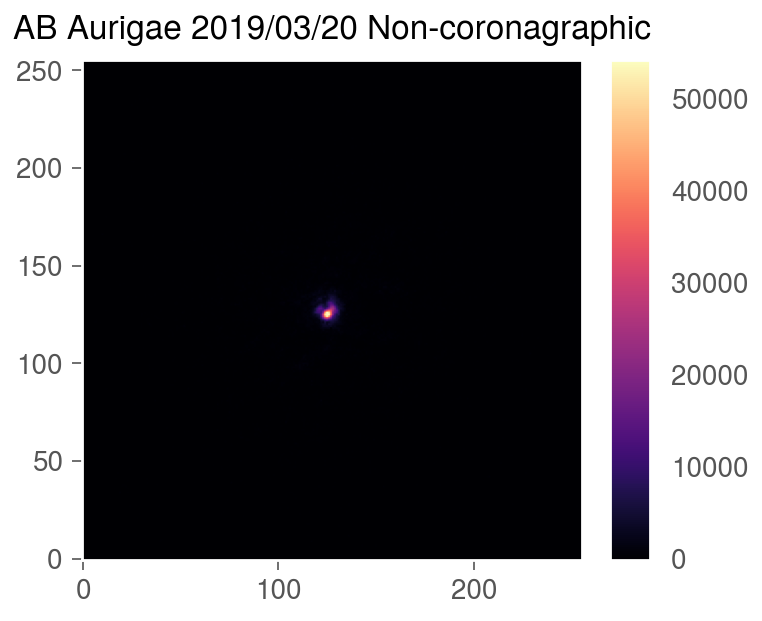

In [4]:
fig, axes = pro.subplots()
frame_idx = 248

frame = abaur20190320_cube[frame_idx]

c = axes[0].imshow(frame, cmap="magma")
fig.colorbar(c)
axes.format(grid=False)
fig.suptitle("AB Aurigae 2019/03/20 Non-coronagraphic")


In [5]:
## do the frame selection
from vampires_dpp.frame_selection import measure_metric

kwargs = dict(center=(128, 128), window=30)
metric_max = measure_metric(abaur20190320_cube, metric="max", **kwargs)
metric_l2norm = measure_metric(abaur20190320_cube, metric="l2norm", **kwargs)
metric_normvar = measure_metric(abaur20190320_cube, metric="normvar", **kwargs)


Text(0.5, 0.98, 'AB Aurigae 2019/03/20 Non-coronagraphic')

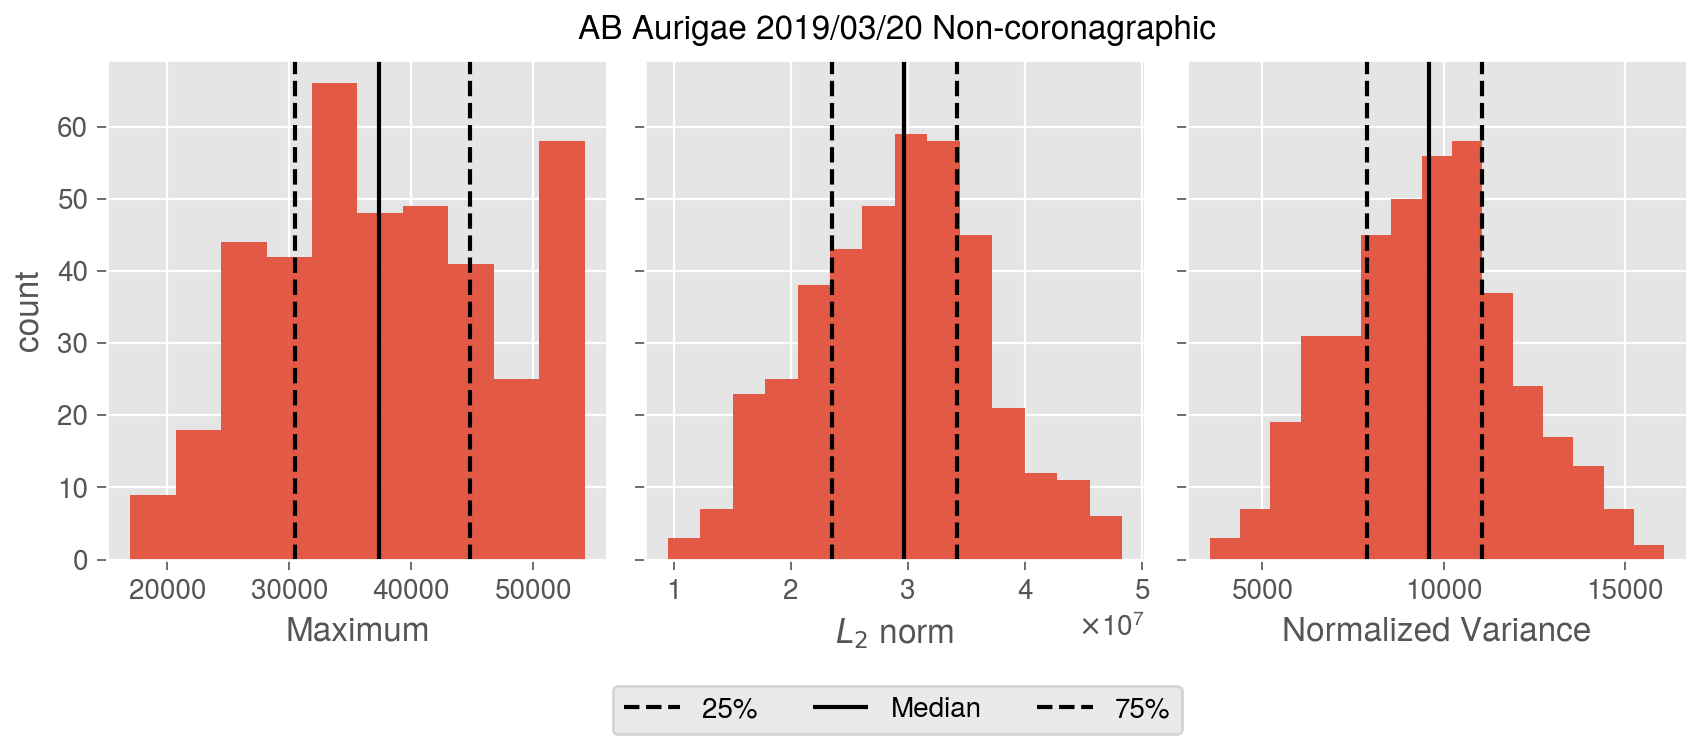

In [6]:
fig, axes = pro.subplots(ncols=3, sharex=0)

labels = ["Maximum", r"$L_2$ norm", "Normalized Variance"]
metrics = [metric_max, metric_l2norm, metric_normvar]

handles = None
for label, samples, ax in zip(labels, metrics, axes):
    ax.hist(samples, bins="auto", fillalpha=0.9, lw=1)
    qs = np.quantile(samples, [0.25, 0.5, 0.75])
    ls = "--", "-", "--"
    handles = [ax.axvline(q, color="k", ls=l) for q, l in zip(qs, ls)]
    ax.format(xlabel=label, ylabel="count")
fig.legend(handles, ["25%", "Median", "75%"], loc="b")
fig.suptitle("AB Aurigae 2019/03/20 Non-coronagraphic")


In [7]:
from vampires_dpp.image_registration import psf_offsets
from vampires_dpp.image_processing import shift_cube

kwargs = {
    "center": (128, 128),
    "window": 30,
    "method": "dft",
    "upsample_factor": 10,
    "refidx": metrics[0].argmax(),
}

cutoffs = [0, 0.25, 0.5, 0.75]

offsets = psf_offsets(abaur20190320_cube, **kwargs)

collapsed_frames = []
for metric in metrics:
    qs = np.quantile(metric, cutoffs)
    masks = [metric > q for q in qs]
    registered = [
        shift_cube(abaur20190320_cube[mask], -offsets[mask]) for mask in masks
    ]
    collapsed_frames.append([np.median(r, 0, overwrite_input=True) for r in registered])


Text(0.5, 0.98, 'AB Aurigae 2019/03/20 Non-coronagraphic')

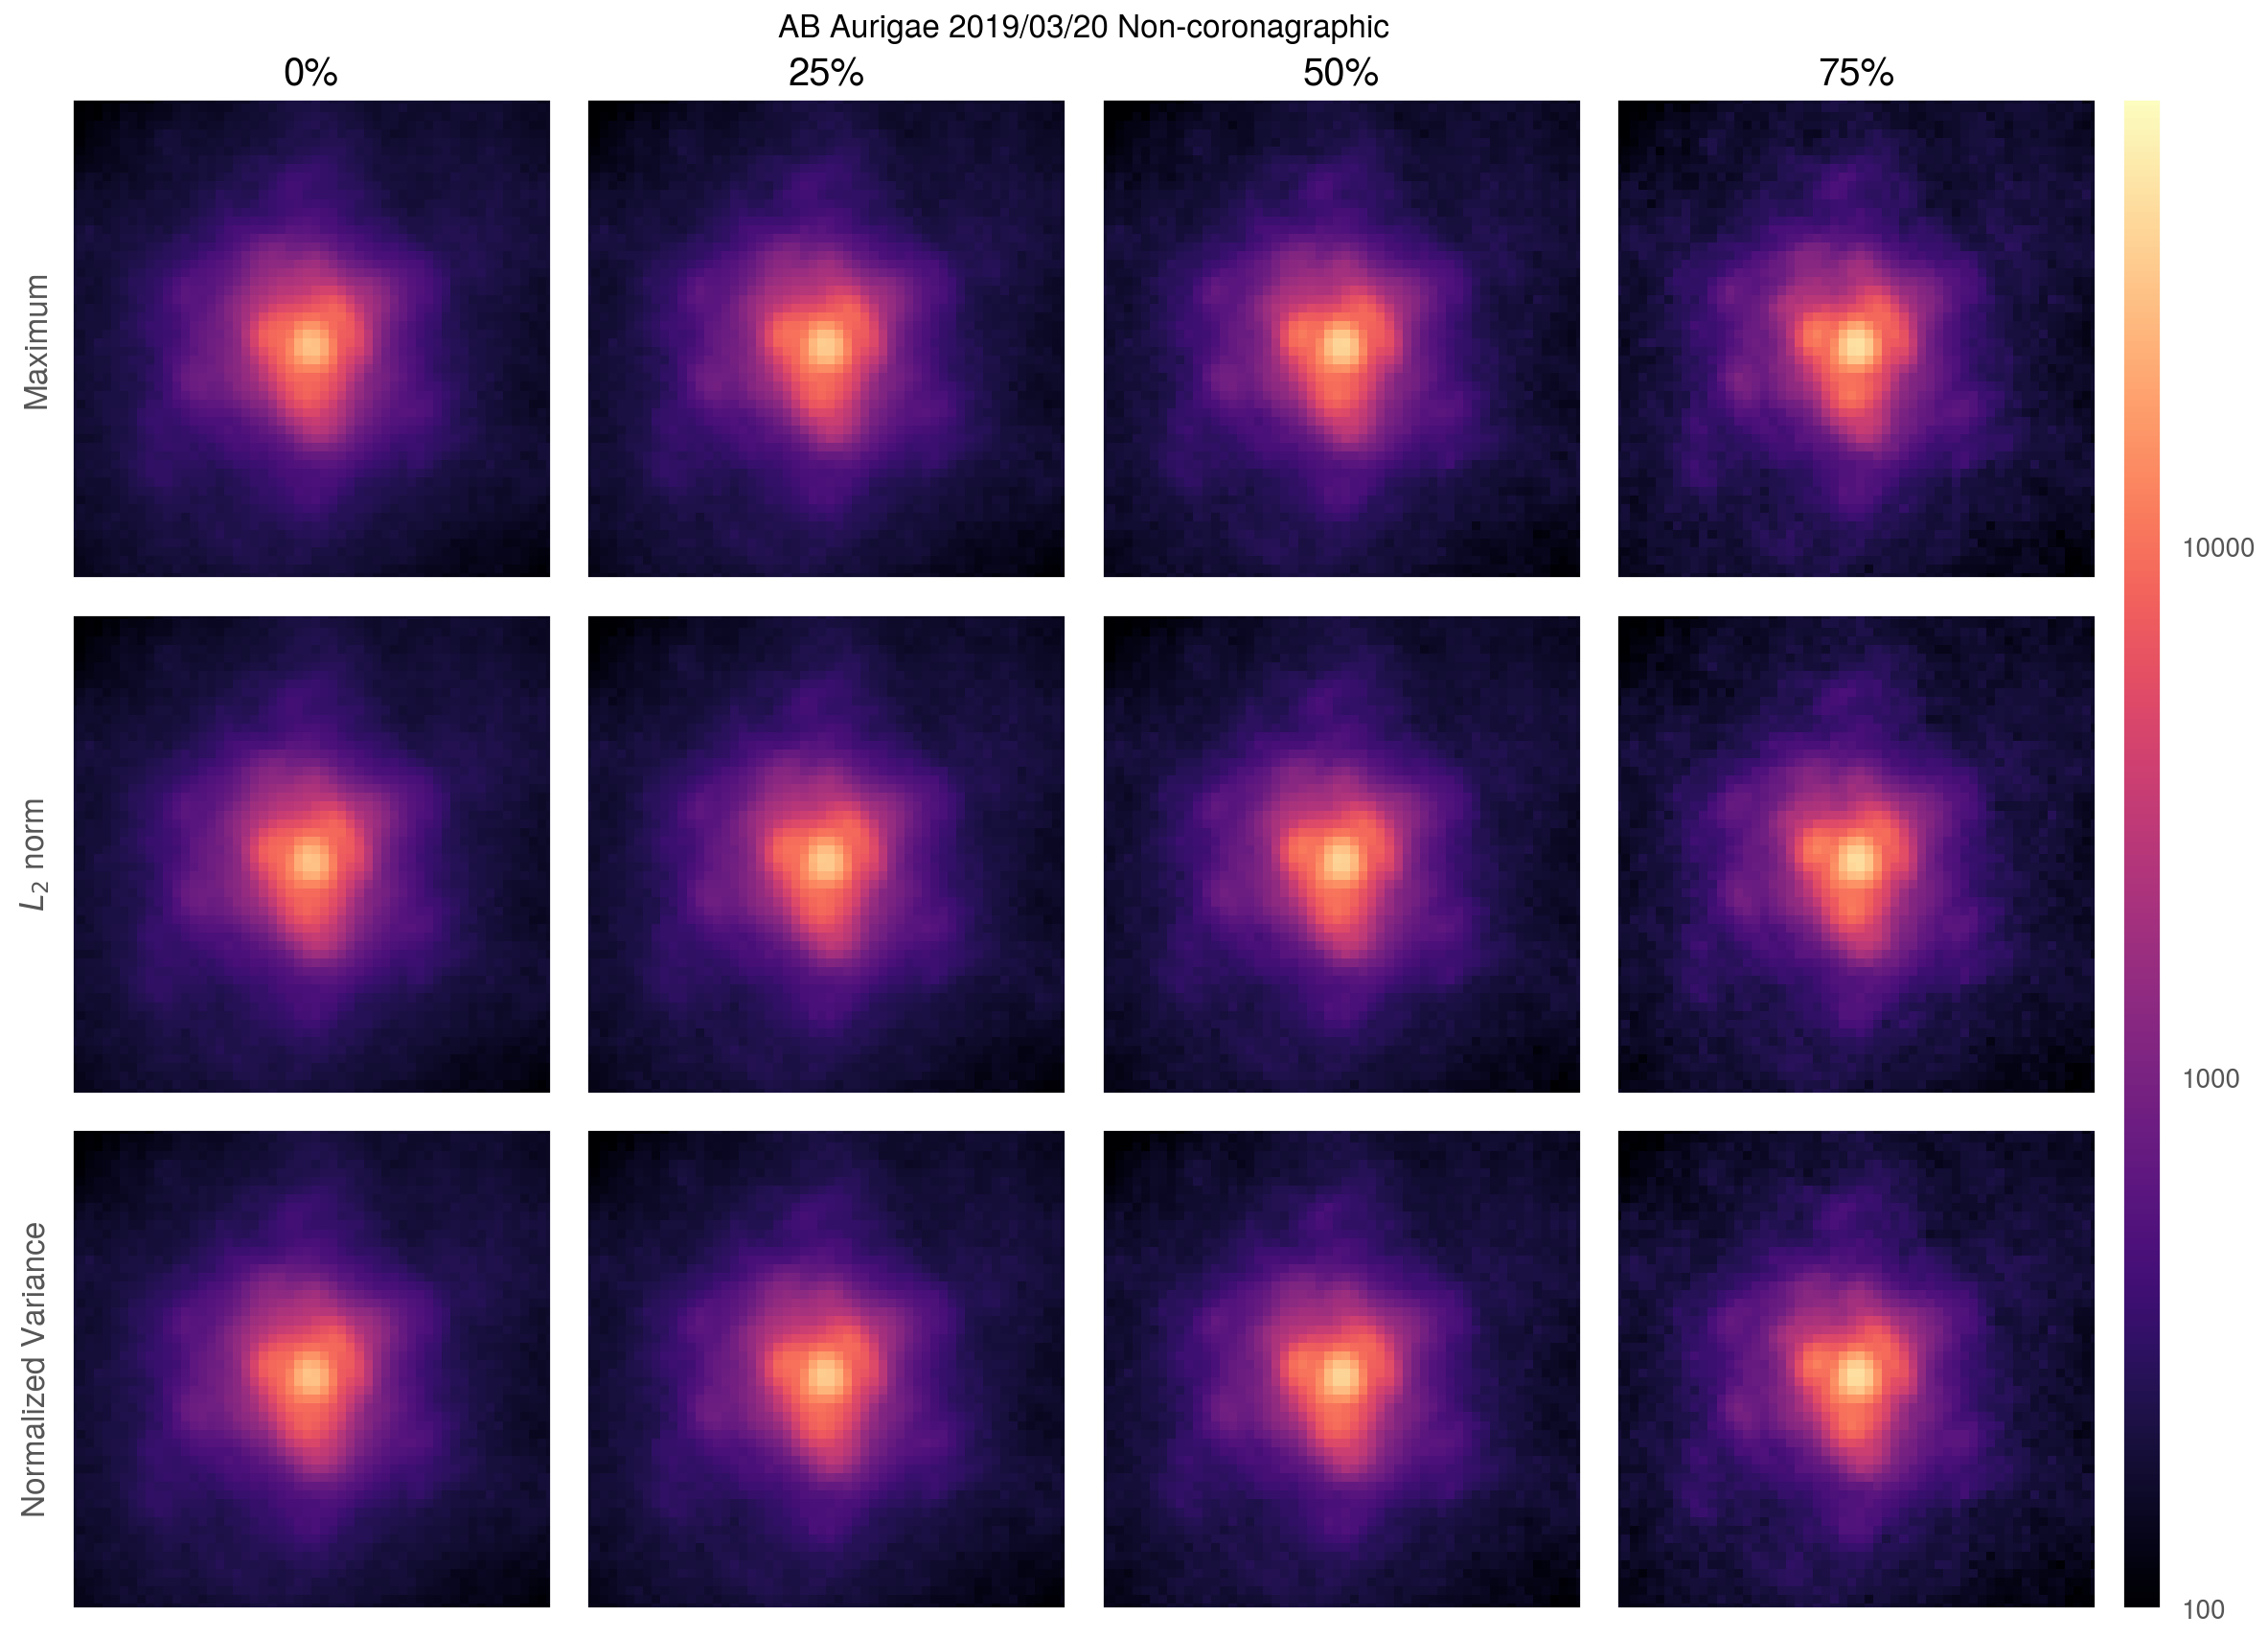

In [8]:
fig, axes = pro.subplots(nrows=3, ncols=4, share=0)

axes[0, 0].format(ylabel="No Frame Selection")
for i, frames in enumerate(collapsed_frames):
    axes[i, 0].format(ylabel=labels[i])
    for j, fr in zip(range(4), frames):
        c = axes[i, j].imshow(fr, cmap="magma", norm="log", vmin=100, vmax=7e4)
fig.colorbar(c)

for j in range(4):
    axes[0, j].format(title=f"{cutoffs[j] * 100:.0f}%")

axes.format(xticks=False, yticks=False, xlim=(100, 155), ylim=(100, 155))
fig.suptitle("AB Aurigae 2019/03/20 Non-coronagraphic")


## Example 2: Coronagraphic data with Satellite Spots

This example uses coronagraphic data of AB Aurigae from 2022/02/24. These data are also polarimetric but we will ignore that, again. These data are taking in poor seeing conditions with long exposure times (0.3 s) and have much lower S/N than the non-coronagraphic data above.

In [9]:
abaur20220224_cube, abaur20220224_hdr = fits.getdata(
    datadir / "ABAur_02__RS___20220224_750-50_LyotStop_00_cam1_fix_calib_FLC1.fits",
    header=True,
)


Text(0.5, 0.98, 'AB Aurigae 2022/02/24 Coronagraphic')

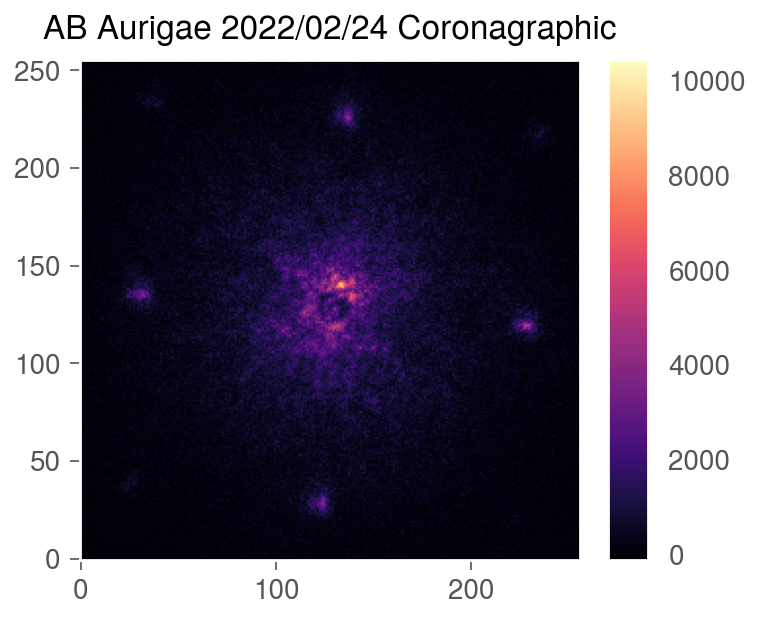

In [10]:
fig, axes = pro.subplots()
frame_idx = 112

frame = abaur20220224_cube[frame_idx]

c = axes[0].imshow(frame, cmap="magma")
fig.colorbar(c)
axes.format(grid=False)
fig.suptitle("AB Aurigae 2022/02/24 Coronagraphic")


In [11]:
from vampires_dpp.satellite_spots import lamd_to_pixel
from vampires_dpp.frame_selection import measure_satellite_spot_metrics

# radius of satellite spots
radius = lamd_to_pixel(31.6, abaur20220224_hdr["U_FILTER"])

kwargs = {"radius": radius, "center": (130, 130), "window": 30}

metric_satspot_max = measure_satellite_spot_metrics(
    abaur20220224_cube, metric="max", **kwargs
)
metric_satspot_l2norm = measure_satellite_spot_metrics(
    abaur20220224_cube, metric="l2norm", **kwargs
)
metric_satspot_normvar = measure_satellite_spot_metrics(
    abaur20220224_cube, metric="normvar", **kwargs
)


Text(0.5, 0.98, 'AB Aurigae 2022/02/24 Coronagraphic')

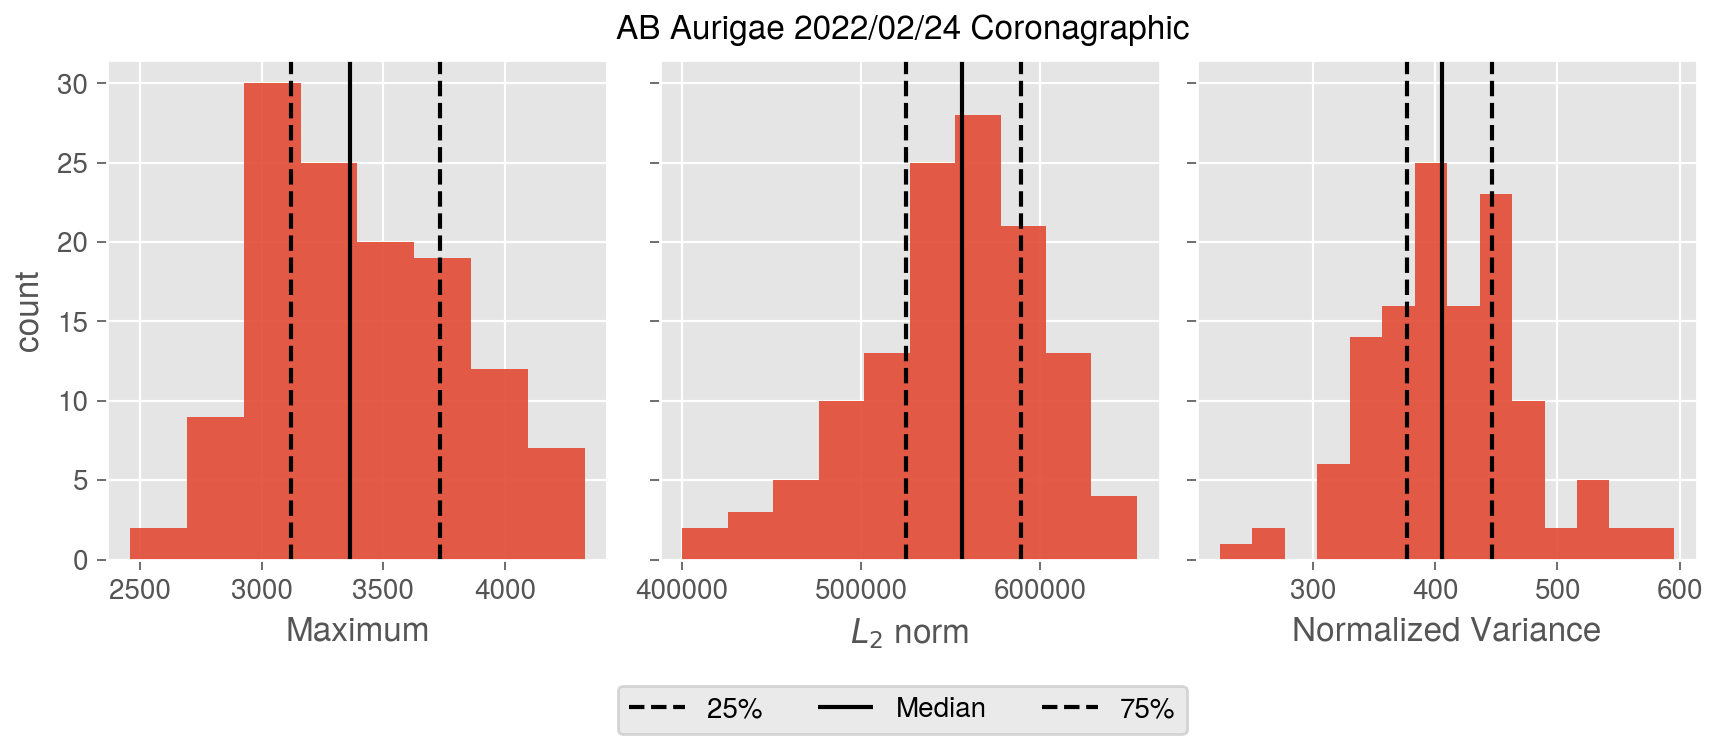

In [12]:
fig, axes = pro.subplots(ncols=3, sharex=0)

labels = ["Maximum", r"$L_2$ norm", "Normalized Variance"]
metrics = [metric_satspot_max, metric_satspot_l2norm, metric_satspot_normvar]

handles = None
for label, samples, ax in zip(labels, metrics, axes):
    ax.hist(samples, bins="auto", fillalpha=0.9, lw=1)
    qs = np.quantile(samples, [0.25, 0.5, 0.75])
    ls = "--", "-", "--"
    handles = [ax.axvline(q, color="k", ls=l) for q, l in zip(qs, ls)]
    ax.format(xlabel=label, ylabel="count")
fig.legend(handles, ["25%", "Median", "75%"], loc="b")
fig.suptitle("AB Aurigae 2022/02/24 Coronagraphic")


In [13]:
from vampires_dpp.image_registration import satellite_spot_offsets

kwargs = {
    "center": (130, 130),
    "window": 30,
    "method": "com",
    "radius": radius,
}

cutoffs = [0, 0.25, 0.5, 0.75]

offsets = satellite_spot_offsets(abaur20220224_cube, **kwargs)

collapsed_satspot_frames = []
for metric in metrics:
    qs = np.quantile(metric, cutoffs)
    masks = [metric > q for q in qs]
    registered = [
        shift_cube(abaur20220224_cube[mask], -offsets[mask]) for mask in masks
    ]
    collapsed_satspot_frames.append(
        [np.median(r, 0, overwrite_input=True) for r in registered]
    )


Text(0.5, 0.98, 'AB Aurigae 2022/02/24 Coronagraphic')

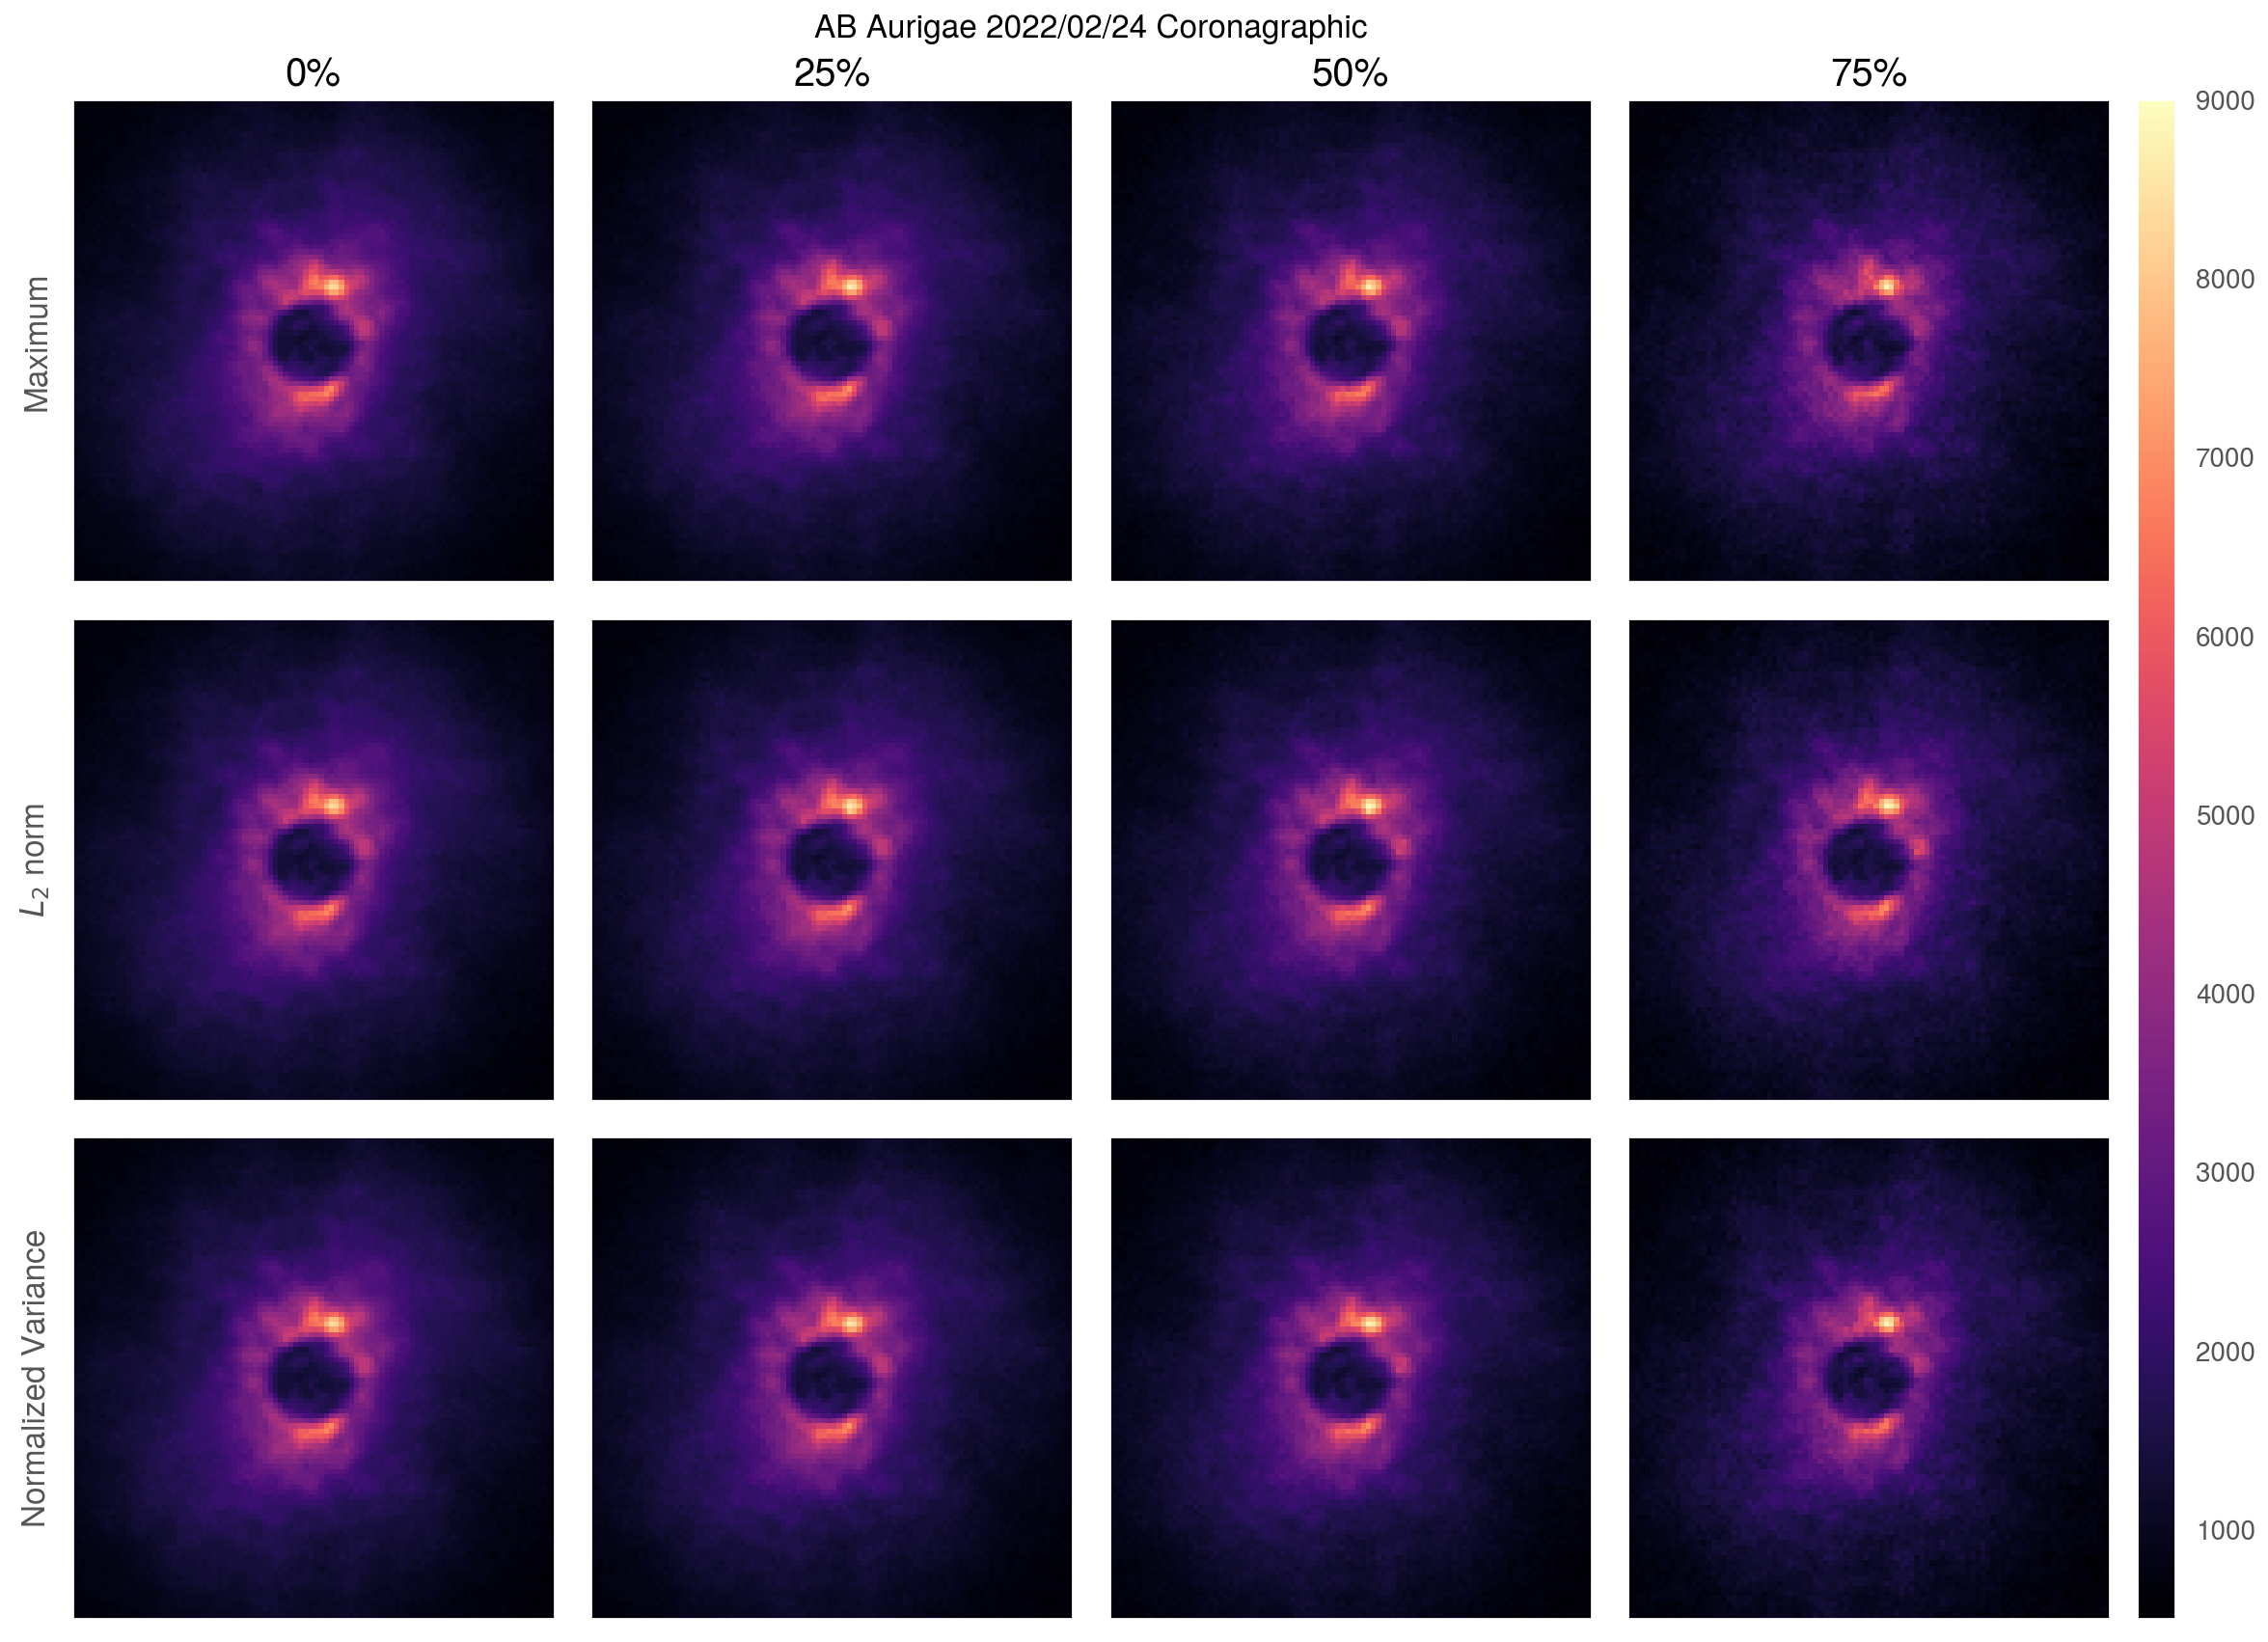

In [14]:
fig, axes = pro.subplots(nrows=3, ncols=4, share=0)


axes[0, 0].format(ylabel="No Frame Selection")
for i, frames in enumerate(collapsed_satspot_frames):
    axes[i, 0].format(ylabel=labels[i])
    for j, fr in zip(range(4), frames):
        c = axes[i, j].imshow(fr, cmap="magma", vmin=500, vmax=9e3)

fig.colorbar(c)

for j in range(4):
    axes[0, j].format(title=f"{cutoffs[j] * 100:.0f}%")


axes.format(xlim=(80, 175), ylim=(80, 175), xticks=False, yticks=False)
fig.suptitle("AB Aurigae 2022/02/24 Coronagraphic")


Text(0.5, 0.98, 'AB Aurigae 2022/02/24 Coronagraphic')

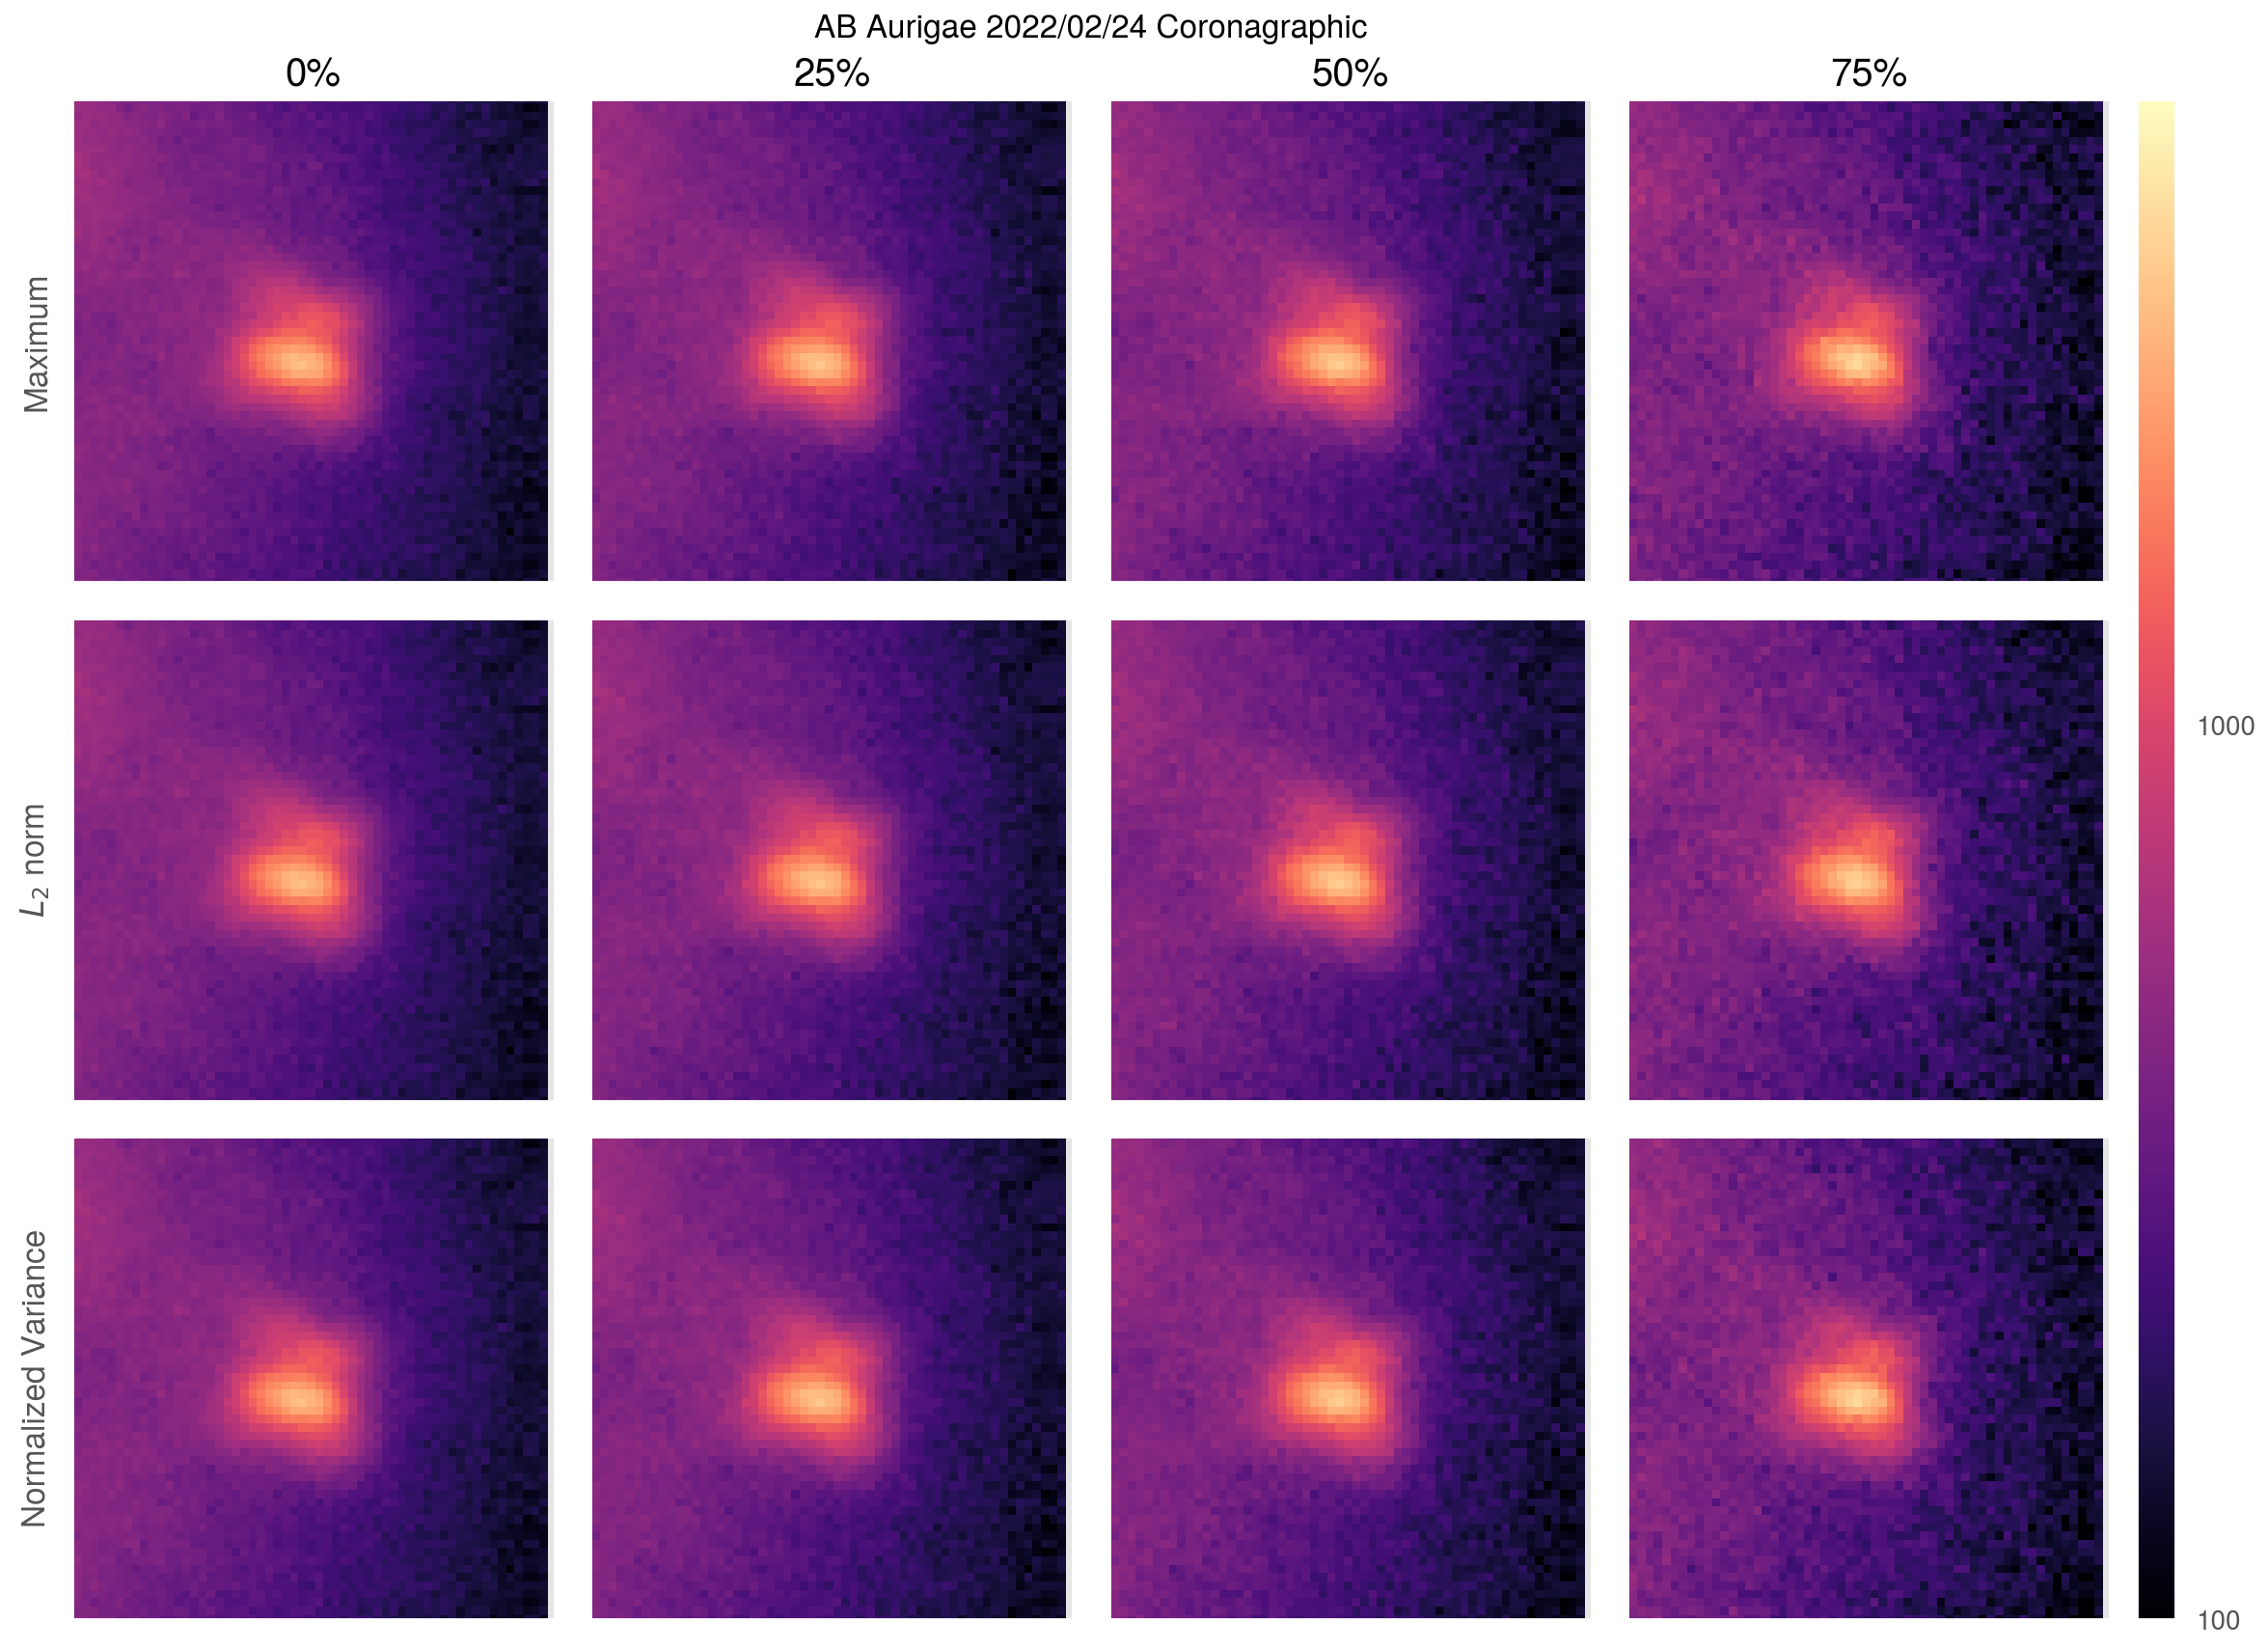

In [15]:
fig, axes = pro.subplots(nrows=3, ncols=4, share=0)


axes[0, 0].format(ylabel="No Frame Selection")
for i, frames in enumerate(collapsed_satspot_frames):
    axes[i, 0].format(ylabel=labels[i])
    for j, fr in zip(range(4), frames):
        c = axes[i, j].imshow(fr, cmap="magma", norm="log", vmin=100, vmax=5e3)
fig.colorbar(c, loc="r")

for j in range(4):
    axes[0, j].format(title=f"{cutoffs[j] * 100:.0f}%")

axes.format(
    xticks=False,
    yticks=False,
    xlim=(98 + radius * np.cos(np.deg2rad(-4)), 156 + radius * np.cos(np.deg2rad(-4))),
    ylim=(98 + radius * np.sin(np.deg2rad(-4)), 156 + radius * np.sin(np.deg2rad(-4))),
)
fig.suptitle("AB Aurigae 2022/02/24 Coronagraphic")
